In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context='talk')
%matplotlib inline

In [3]:
class EncoderDecoder(nn.Module):
    
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        # 输入和输出的embedding
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        # Decoder 后的 Linear + softmax
        self.generator = generator
    
    def encode(self, src, src_mask):
        src_embed = self.src_embed(src)
        return self.encoder(src_embed, src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        tgt_embed = self.tgt_embed(tgt)
        return self.decoder(tgt_embed, memory, src_mask, tgt_mask)
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        encode_output = self.encode(src, src_mask)
        return self.decode(encode_output, src_mask, tgt, tgt_mask)

In [4]:
class Generator(nn.Module):
    
    def __init__(self, d_model, vocab):
        """
        根据Decoder的隐藏状态输出一个词
        Args:
        d_model: Decoder输出的大小
        vocab: 词典大小
        """
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        linear_output = self.proj(x)
        return F.log_softmax(linear_output, dim=-1)

In [5]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [6]:
class LayerNorm(nn.Module):
    
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x: torch.Tensor):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        # 加一个LayerNorm
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [8]:
class SublayerConnection(nn.Module):
    """
    LayerNorm + sublayer(Self-Attention / Dense) + dropout + 残差连接
    LayerNorm放在前面，与原始论文存在差别（原始论文放在最后）
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        norm_output = self.norm(x)
        sublayer_output = sublayer(norm_output)
        return x + self.dropout(sublayer_output)

In [9]:
class EncoderLayer(nn.Module):
    
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [10]:
class Decoder(nn.Module):
    
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [12]:
class DecoderLayer(nn.Module):
    
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_word
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))  # self attn: q, k, v
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))  # cross attn: q, k, v
        return self.sublayer[2](x, self.feed_forward)

In [13]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    mask = np.triu(np.ones(attn_shape), k=1).astype(np.uint8)
    return torch.from_numpy(mask) == 0

tensor([[ True, False, False, False, False, False],
        [ True,  True, False, False, False, False],
        [ True,  True,  True, False, False, False],
        [ True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True]])

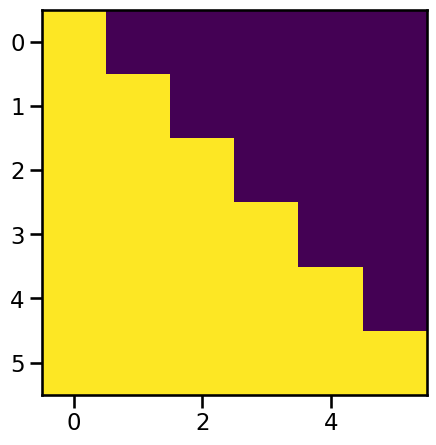

In [15]:
plt.figure(figsize=(5, 5))
result = subsequent_mask(6)[0]
plt.imshow(result)
result

In [16]:
def attention(q, k, v, mask=None, droupout=None):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.sofrmax(scores, dim=-1)
    if droupout is not None:
        p_attn = droupout(p_attn)
    
    return torch.matmul(p_attn, v), p_attn